**Dataset: Identificación de las tecnologias implementadas por las ISP en el departamento de Santander y la distribución de acceso a internet fijo en la población.**

*Elaborado por: Daniel Pachec

---

In [528]:
#Importing packages
import numpy as np
import pandas as pd
import statsmodels.api as sm
from sklearn import preprocessing
import re as re
import matplotlib as mpl
import plotly.graph_objects as go
import plotly.express as px
import matplotlib.pylab as pylab
import seaborn as sns
from pandas.tseries.offsets import *

#librerias necesarias para graficar y realizar algunas modificaciones en los graficos
import matplotlib.pyplot as plt
import seaborn as sb
from mpl_toolkits.mplot3d import Axes3D
#lirebria necesaria para usar el modulo de clusterizacion k-vecinos
from sklearn.cluster import KMeans
#libreria necesaria para computar la distancia entre un grupo de puntos y uno en especifico
from sklearn.metrics import pairwise_distances_argmin_min
#librerias necesarias para la normalizacion de un rango de datos
from sklearn.preprocessing import normalize
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import LabelEncoder
#libreria necesaria para trabajar con modulos de clusterizacion de tipo jerarquicos
import scipy.cluster.hierarchy as shc
#libreria necesaria para trabajar con modulos de clusterizacion de Mezcla Gausiana
from sklearn.mixture import GaussianMixture
#libreria necesaria para trabajar con modulos de clusterizacion de tipo aglomerativos
from sklearn.cluster import AgglomerativeClustering
#Liberia necesaria para trabajar con supuesto multivariable de Criterio KMO y Esfericidad de Barlett
!pip install factor_analyzer
from factor_analyzer import FactorAnalyzer, calculate_kmo, calculate_bartlett_sphericity 
#librerias necesarias para trabajar con método de descomposicion PCA
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import scale
import warnings
warnings.filterwarnings('ignore')

In [529]:
# Importing Dataset 1
internet_df = pd.read_csv("https://raw.githubusercontent.com/jadapache/Santanderconectado/main/Internet_Fijo_Accesos_por_tecnolog_a_y_segmento.csv")

In [530]:
#General information of the dataset1:
print(internet_df.head())
print(internet_df.info())

    AÑO  TRIMESTRE  ... VELOCIDAD_SUBIDA No DE ACCESOS
0  2019          3  ...                3             1
1  2019          3  ...                1            26
2  2019          4  ...                5            48
3  2019          3  ...               25             2
4  2019          3  ...                1           211

[5 rows x 10 columns]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52494 entries, 0 to 52493
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   AÑO               52494 non-null  int64 
 1   TRIMESTRE         52494 non-null  int64 
 2   PROVEEDOR         52494 non-null  object
 3   DEPARTAMENTO      52494 non-null  object
 4   MUNICIPIO         52494 non-null  object
 5   SEGMENTO          52494 non-null  object
 6   TECNOLOGIA        52494 non-null  object
 7   VELOCIDAD_BAJADA  52494 non-null  int64 
 8   VELOCIDAD_SUBIDA  52494 non-null  int64 
 9   No DE ACCESOS     52494 non

#Procesamiento de los datos

In [531]:
#Para DATASET 1 Se convierte columna AÑO a tipo DATETIME y se une con TRIMESTRE en columna FECHA
internet_df['AÑO'] = pd.to_datetime(internet_df['AÑO'], format="%Y") 
internet_df.insert(0, 'FECHA', internet_df.mean(1))
internet_df['FECHA'] = internet_df.apply(lambda x:(x['AÑO'] + BQuarterBegin(x['TRIMESTRE'])), axis=1) 
internet_df['FECHA'] = internet_df['FECHA'].dt.strftime('%Y-%m')#Se cambia tipo DATETIME a STR con el fin de pulir los histogramas correspondientes a los estratos
internet_df.drop(['AÑO','TRIMESTRE'],axis=1,inplace=True)#Se borran columnas AÑO y TRIMESTRE

In [532]:
#Renombramos los datos
internet = [internet_df]
for dataset in internet:
    dataset['SEGMENTO'] = dataset['SEGMENTO'].replace('RESIDENCIAL - ESTRATO 1', 'ESTRATO 1')
    dataset['SEGMENTO'] = dataset['SEGMENTO'].replace('RESIDENCIAL - ESTRATO 2', 'ESTRATO 2')
    dataset['SEGMENTO'] = dataset['SEGMENTO'].replace('RESIDENCIAL - ESTRATO 3', 'ESTRATO 3')
    dataset['SEGMENTO'] = dataset['SEGMENTO'].replace('RESIDENCIAL - ESTRATO 4', 'ESTRATO 4')
    dataset['SEGMENTO'] = dataset['SEGMENTO'].replace('RESIDENCIAL - ESTRATO 5', 'ESTRATO 5')
    dataset['SEGMENTO'] = dataset['SEGMENTO'].replace('RESIDENCIAL - ESTRATO 6', 'ESTRATO 6')
    dataset['TECNOLOGIA'] = dataset['TECNOLOGIA'].replace('FIBER TO THE CABINET (FTTC)', 'FTTC')
    dataset['TECNOLOGIA'] = dataset['TECNOLOGIA'].replace('FIBER TO THE HOME (FTTH)', 'FTTH')
    dataset['TECNOLOGIA'] = dataset['TECNOLOGIA'].replace('FIBER TO THE X (FTTX)', 'FTTX')
    dataset['TECNOLOGIA'] = dataset['TECNOLOGIA'].replace('HYBRID FIBER COAXIAL (HFC)', 'HFC')
    dataset['TECNOLOGIA'] = dataset['TECNOLOGIA'].replace('OTRAS TECNOLOG�AS INAL�MBRICAS', '+ INALAMBRICAS')


In [533]:
#Elminamos los segmentos correspondientes a Corporativos, ya que el análisis está dirigido al acceso a internet fijo hogar
internet_df = internet_df.drop(internet_df[internet_df['SEGMENTO']=='CORPORATIVO'].index)
internet_df = internet_df.drop(internet_df[internet_df['SEGMENTO']=='SIN ESTRATIFICAR'].index)

In [534]:
#Generamos variables dummy de la columna tecnologia
tecnologia_dummy = pd.get_dummies(internet_df["TECNOLOGIA"])
internet_df = pd.concat([internet_df, tecnologia_dummy], axis=1)#Unimos las variables dummy al dataset
#internet_df= internet_df.drop(internet_df.columns[[2, 5]], axis=1) #Eliminamos columnas departamento y tecnologia

Detección de outliers en Velocidad de Bajada

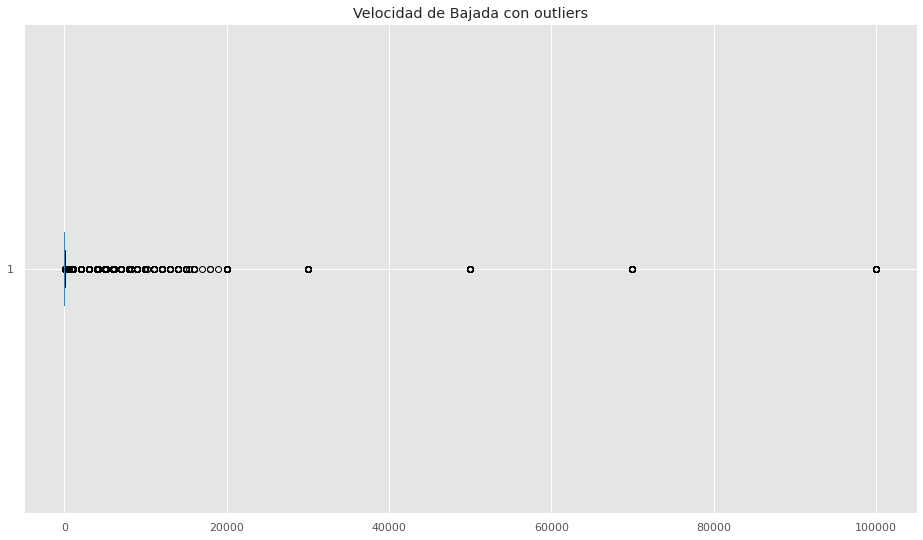

In [535]:
plt.title('Velocidad de Bajada con outliers')
plt.boxplot(internet_df["VELOCIDAD_BAJADA"],vert=False)
plt.show()

In [536]:
#Cálculo estádistico para boxploit
Q1 = internet_df['VELOCIDAD_BAJADA'].quantile(0.25)
print("Primer Cuartil", Q1)

Q3 = internet_df['VELOCIDAD_BAJADA'].quantile(0.75)
print("Tercer Cuartil", Q3)

IQR= Q3 - Q1
print("Rango Intecuartil", IQR)

Mediana = internet_df['VELOCIDAD_BAJADA'].median()
print("Mediana", Mediana)

Valor_Minimo = internet_df['VELOCIDAD_BAJADA'].min()
print("Valor Minimo", Valor_Minimo)

Valor_Máximo = internet_df['VELOCIDAD_BAJADA'].max()
print("Valor Máximo", Valor_Máximo)


Primer Cuartil 4.0
Tercer Cuartil 20.0
Rango Intecuartil 16.0
Mediana 8.0
Valor Minimo 0
Valor Máximo 100000


In [537]:
#Cálculo de valores de bigotes inferior y superior
Bigote_inferior = (Q1 - 1.5 * IQR) #Restando 1.5 veces el rango intercuantil al Primer Cuartil
print("Bigote Inferior \n", Bigote_inferior)

Bigote_superior = (Q3 + 1.5 * IQR) #Sumando 1.5 veces el rango intercuantil al Tercer Cuartil
print("Bigote Superior \n", Bigote_superior)

Bigote Inferior 
 -20.0
Bigote Superior 
 44.0


In [538]:
#Ubicación de filas en las que hay outliers
ubi_outliers = (internet_df['VELOCIDAD_BAJADA'] < Bigote_inferior) | (internet_df['VELOCIDAD_BAJADA'] > Bigote_superior)
print("\n Ubicación de Outliers \n", ubi_outliers)

#Obtener valores de los outliers
outliers = internet_df[ubi_outliers]
outliers = outliers.sort_values("VELOCIDAD_BAJADA")
print("\n Lista de Outliers \n", outliers)


 Ubicación de Outliers 
 0        False
1        False
3         True
5        False
6        False
         ...  
52484    False
52485    False
52489    False
52492     True
52493    False
Name: VELOCIDAD_BAJADA, Length: 30447, dtype: bool

 Lista de Outliers 
          FECHA                                          PROVEEDOR  ... WIMAX XDSL
30723  2020-06                COMUNICACION CELULAR S A COMCEL S A  ...     0    0
26072  2020-06                COMUNICACION CELULAR S A COMCEL S A  ...     0    0
9178   2020-03                COMUNICACION CELULAR S A COMCEL S A  ...     0    0
18750  2019-12                COMUNICACION CELULAR S A COMCEL S A  ...     0    0
46621  2020-09                COMUNICACION CELULAR S A COMCEL S A  ...     0    0
...        ...                                                ...  ...   ...  ...
24934  2018-12  EMPRESA DE TELECOMUNICACIONES DE BUCARAMANGA S...  ...     0    0
10487  2018-12  EMPRESA DE TELECOMUNICACIONES DE BUCARAMANGA S...  ...     0    

In [539]:
#Ubicación de filas en las que no hay outliers
ubi_notoutliers = (internet_df['VELOCIDAD_BAJADA'] >= Bigote_inferior) & (internet_df['VELOCIDAD_BAJADA'] <= Bigote_superior)
notoutliers = internet_df[ubi_notoutliers]

In [540]:
print(ubi_notoutliers.value_counts())

True     26134
False     4313
Name: VELOCIDAD_BAJADA, dtype: int64


In [541]:
bajadaindex = internet_df[~ubi_notoutliers].index # INVERT removed_outliers!!
print(bajadaindex)

Int64Index([    3,    17,    43,    45,    54,    69,    71,   100,   107,
              124,
            ...
            52261, 52273, 52307, 52309, 52310, 52364, 52374, 52397, 52399,
            52492],
           dtype='int64', length=4313)


In [542]:
import plotly.graph_objs as go
internet_df.drop(bajadaindex, inplace=True)

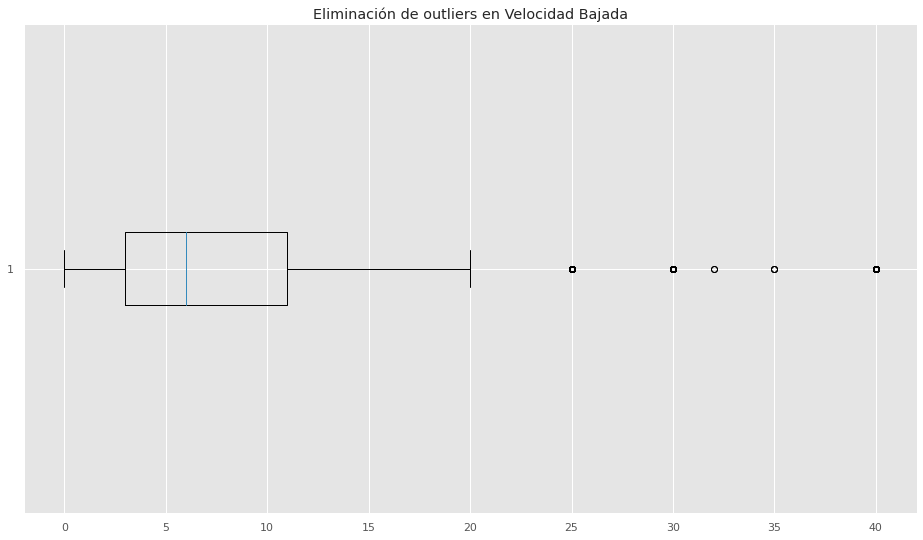

In [543]:
plt.title('Eliminación de outliers en Velocidad Bajada')
plt.boxplot(internet_df["VELOCIDAD_BAJADA"],vert=False)
plt.show()

Detección de Outliers en 'Velocidad de Subida'




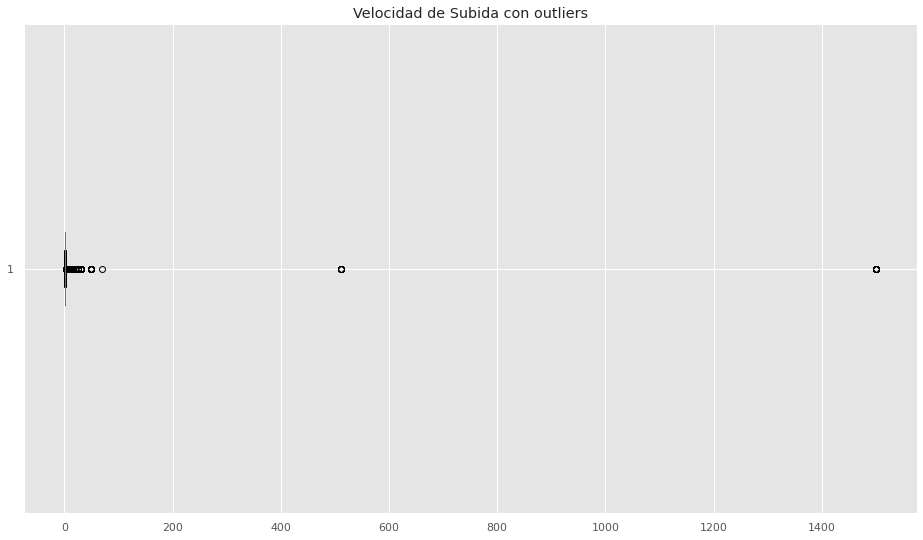

In [544]:
plt.title('Velocidad de Subida con outliers')
plt.boxplot(internet_df["VELOCIDAD_SUBIDA"],vert=False)
plt.show()

In [545]:
#Cálculo estádistico para boxploit
SQ1 = internet_df['VELOCIDAD_SUBIDA'].quantile(0.25)
print("Primer Cuartil", SQ1)

SQ3 = internet_df['VELOCIDAD_SUBIDA'].quantile(0.75)
print("Tercer Cuartil", SQ3)

SIQR= SQ3 - SQ1
print("Rango Intecuartil", SIQR)

SMediana = internet_df['VELOCIDAD_SUBIDA'].median()
print("Mediana", SMediana)

SValor_Minimo = internet_df['VELOCIDAD_SUBIDA'].min()
print("Valor Minimo", SValor_Minimo)

SValor_Máximo = internet_df['VELOCIDAD_SUBIDA'].max()
print("Valor Máximo", SValor_Máximo)

Primer Cuartil 1.0
Tercer Cuartil 2.0
Rango Intecuartil 1.0
Mediana 1.0
Valor Minimo 0
Valor Máximo 1500


In [546]:
#Cálculo de valores de bigotes inferior y superior
EBigote_inferior = (SQ1 - 1.5 * SIQR) #Restando 1.5 veces el rango intercuantil al Primer Cuartil
print("Bigote Inferior \n", EBigote_inferior)

EBigote_superior = (SQ3 + 1.5 * SIQR) #Sumando 1.5 veces el rango intercuantil al Tercer Cuartil
print("Bigote Superior \n", EBigote_superior)

Bigote Inferior 
 -0.5
Bigote Superior 
 3.5


In [547]:
#Ubicación de filas en las que hay outliers
subi_outliers = (internet_df['VELOCIDAD_SUBIDA'] < EBigote_inferior) | (internet_df['VELOCIDAD_SUBIDA'] > EBigote_superior)
#Obtener valores de los outliers
soutliers = internet_df[subi_outliers]
soutliers = soutliers.sort_values("VELOCIDAD_SUBIDA")
print("\n Lista de Outliers \n", soutliers)


 Lista de Outliers 
          FECHA                            PROVEEDOR  ... WIMAX XDSL
52481  2020-06  COMUNICACION CELULAR S A COMCEL S A  ...     0    0
39597  2019-06  COMUNICACION CELULAR S A COMCEL S A  ...     0    0
39539  2019-06  COMUNICACION CELULAR S A COMCEL S A  ...     0    0
10186  2018-12                 TELMEX COLOMBIA S.A.  ...     0    0
39478  2020-09            HUGHES DE COLOMBIA S.A.S.  ...     0    0
...        ...                                  ...  ...   ...  ...
22029  2019-09                   REDNET GROUP S.A.S  ...     0    0
24779  2019-06                   REDNET GROUP S.A.S  ...     0    0
1274   2019-09                   REDNET GROUP S.A.S  ...     0    0
12735  2019-09                   REDNET GROUP S.A.S  ...     0    0
20264  2019-09                   REDNET GROUP S.A.S  ...     0    0

[3924 rows x 19 columns]


In [548]:
#Ubicación de filas en las que no hay outliers
subi_notoutliers = (internet_df['VELOCIDAD_SUBIDA'] >= EBigote_inferior) & (internet_df['VELOCIDAD_SUBIDA'] <= EBigote_superior)
snotoutliers = internet_df[subi_notoutliers]

In [549]:
print(subi_notoutliers.value_counts())

True     22210
False     3924
Name: VELOCIDAD_SUBIDA, dtype: int64


In [550]:
subidaindex = internet_df[~subi_notoutliers].index # INVERT removed_outliers!!
print(subidaindex)

Int64Index([   16,    18,    27,    33,    50,    51,    65,    68,   116,
              148,
            ...
            52348, 52362, 52363, 52408, 52419, 52433, 52465, 52476, 52479,
            52481],
           dtype='int64', length=3924)


In [551]:
import plotly.graph_objs as go
internet_df.drop(subidaindex, inplace=True)

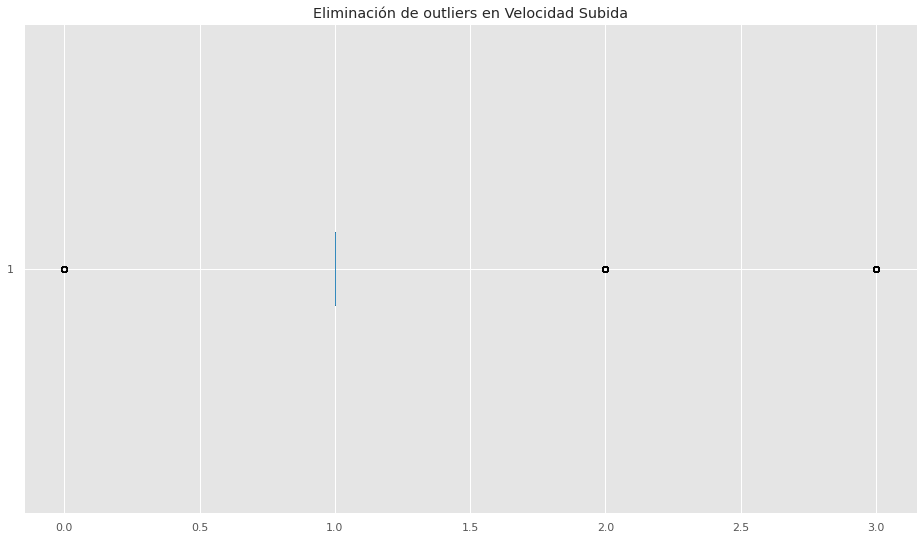

In [552]:
plt.title('Eliminación de outliers en Velocidad Subida')
plt.boxplot(internet_df["VELOCIDAD_SUBIDA"],vert=False)
plt.show()

Detección de Outliers en Nro de Accesos

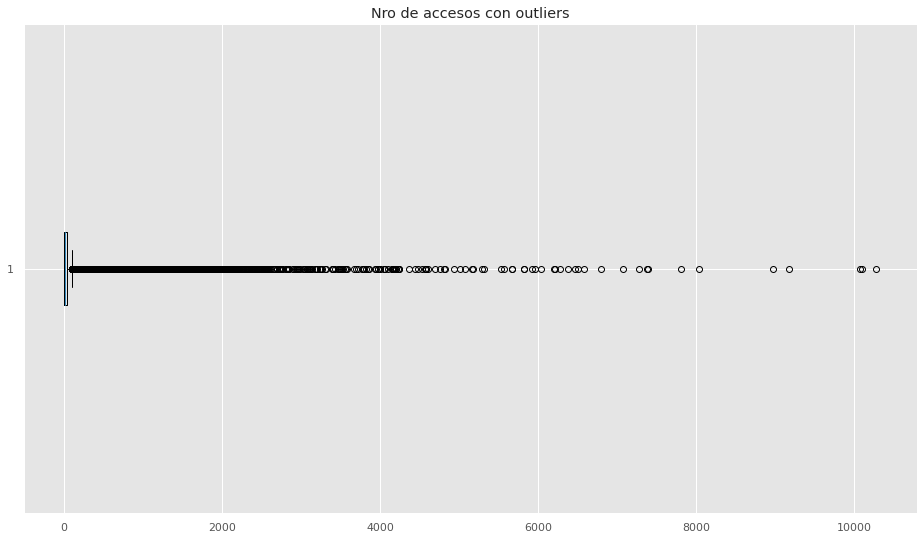

In [553]:
plt.title('Nro de accesos con outliers')
plt.boxplot(internet_df["No DE ACCESOS"],vert=False)
plt.show()

In [554]:
#Cálculo estádistico para boxploit
NQ1 = internet_df['No DE ACCESOS'].quantile(0.25)
print("Primer Cuartil", Q1)

NQ3 = internet_df['No DE ACCESOS'].quantile(0.75)
print("Tercer Cuartil", Q3)

NIQR= Q3 - Q1
print("Rango Intecuartil", IQR)

Mediana = internet_df['No DE ACCESOS'].median()
print("Mediana", Mediana)

Valor_Minimo = internet_df['No DE ACCESOS'].min()
print("Valor Minimo", Valor_Minimo)

Valor_Máximo = internet_df['No DE ACCESOS'].max()
print("Valor Máximo", Valor_Máximo)


Primer Cuartil 4.0
Tercer Cuartil 20.0
Rango Intecuartil 16.0
Mediana 8.0
Valor Minimo 1
Valor Máximo 10273


In [555]:
#Cálculo de valores de bigotes inferior y superior
EBigote_inferior = (NQ1 - 1.5 * NIQR) #Restando 1.5 veces el rango intercuantil al Primer Cuartil
print("Bigote Inferior \n", EBigote_inferior)

EBigote_superior = (NQ3 + 1.5 * NIQR) #Sumando 1.5 veces el rango intercuantil al Tercer Cuartil
print("Bigote Superior \n", EBigote_superior)

Bigote Inferior 
 -22.0
Bigote Superior 
 64.0


In [556]:
#Ubicación de filas en las que hay outliers
nro_outliers = (internet_df['No DE ACCESOS'] < EBigote_inferior) | (internet_df['No DE ACCESOS'] > EBigote_superior)
#Obtener valores de los outliers
noutliers = internet_df[nro_outliers]
noutliers = noutliers.sort_values("No DE ACCESOS")
print("\n Lista de Outliers \n", noutliers)


 Lista de Outliers 
          FECHA                                        PROVEEDOR  ... WIMAX XDSL
11627  2020-03          COLOMBIA TELECOMUNICACIONES S.A. E.S.P.  ...     0    0
29055  2019-03                             TELMEX COLOMBIA S.A.  ...     0    0
18779  2018-12          COLOMBIA TELECOMUNICACIONES S.A. E.S.P.  ...     0    1
52080  2020-09  INTERGALAXIA SOCIEDAD POR ACCIONES SIMPLIFICADA  ...     0    0
19297  2019-03             AZTECA COMUNICACIONES COLOMBIA S.A.S  ...     0    0
...        ...                                              ...  ...   ...  ...
31973  2019-06              COMUNICACION CELULAR S A COMCEL S A  ...     0    0
34694  2018-06                             TELMEX COLOMBIA S.A.  ...     0    0
32674  2019-03                             TELMEX COLOMBIA S.A.  ...     0    0
29649  2018-09                             TELMEX COLOMBIA S.A.  ...     0    0
29762  2018-12                             TELMEX COLOMBIA S.A.  ...     0    0

[4354 rows x 19 c

In [557]:
#Ubicación de filas en las que no hay outliers
nro_outliers = (internet_df['No DE ACCESOS'] >= EBigote_inferior) & (internet_df['No DE ACCESOS'] <= EBigote_superior)
nnotoutliers = internet_df[nro_outliers]

In [558]:
print(nro_outliers.value_counts())

True     17856
False     4354
Name: No DE ACCESOS, dtype: int64


In [559]:
nroindex = internet_df[~nro_outliers].index # INVERT removed_outliers!!
print(nroindex)

Int64Index([    9,    11,    24,    37,   108,   141,   150,   155,   163,
              166,
            ...
            52372, 52373, 52385, 52407, 52413, 52427, 52438, 52458, 52467,
            52473],
           dtype='int64', length=4354)


In [560]:
import plotly.graph_objs as go
internet_df.drop(nroindex, inplace=True)

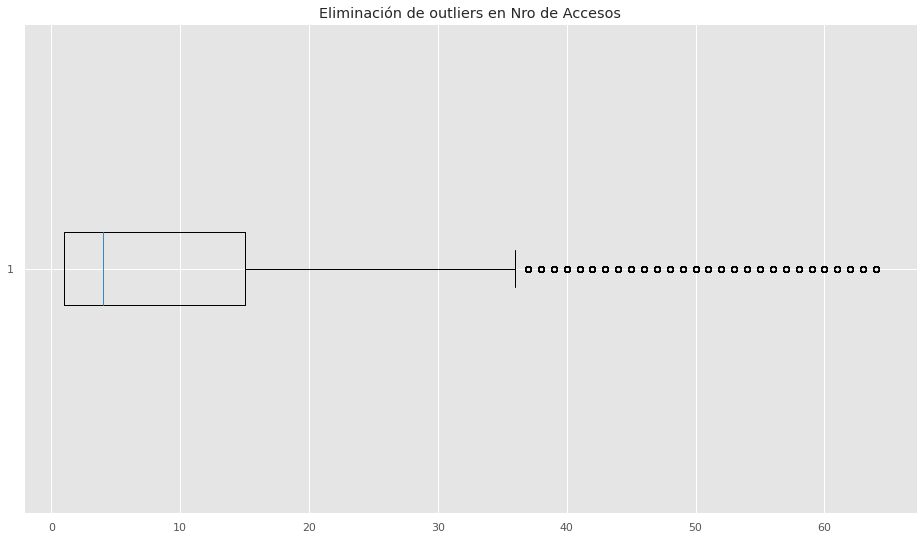

In [561]:
plt.title('Eliminación de outliers en Nro de Accesos')
plt.boxplot(internet_df["No DE ACCESOS"],vert=False)
plt.show()

In [562]:
#Hacemos dataset en base a datos especificos
rec = internet_df[['TECNOLOGIA']]
rec.sort_values('TECNOLOGIA', inplace=True)
rec = rec.drop_duplicates().reset_index(drop=True)

rec.head()

#acceso_internet = internet_df[['MUNICIPIO', 'No DE ACCESOS', '+ INALAMBRICAS','CABLE','FTTC','FTTH','FTTX', 'HFC', 'SATELITAL', 'WIFI', 'WIMAX', 'XDSL']]
acceso_internet = internet_df[['TECNOLOGIA', 'No DE ACCESOS']]
acceso_internet = acceso_internet.groupby("TECNOLOGIA", axis=0).sum().reset_index()#Reducimos la extensión del DataFrame Sumando número de casos
acceso_internet['TECNOLOGIA']=rec['TECNOLOGIA']
acceso_internet.head()

,TECNOLOGIA,No DE ACCESOS
0,+ INALAMBRICAS,28573
1,CABLE,21408
2,FTTC,18264
3,FTTH,5013
4,FTTX,10788


# Analizar los datos procesados

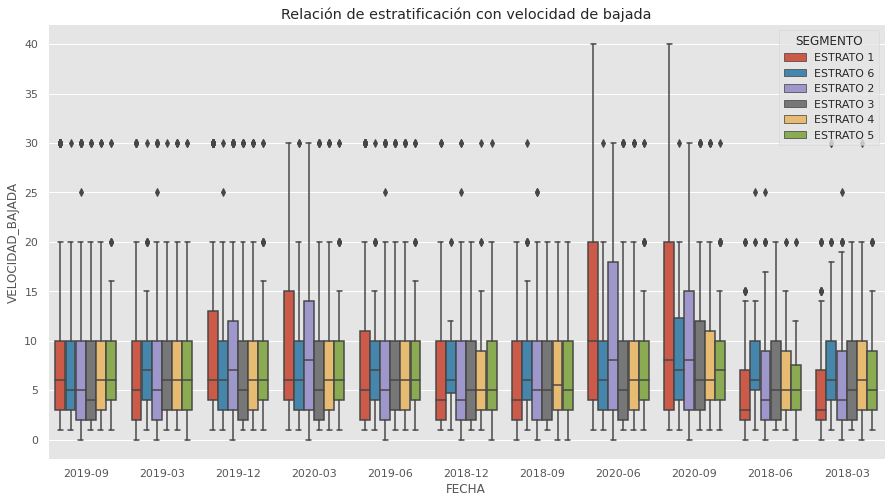

In [563]:
#Gráfica relación estratificación con velocidad de bajada en Bucaramanga
plt.figure(figsize=(15,8))
plt.title('Relación de estratificación con velocidad de bajada')
sns.boxplot(data=internet_df, y=notoutliers["VELOCIDAD_BAJADA"], x="FECHA", hue='SEGMENTO')

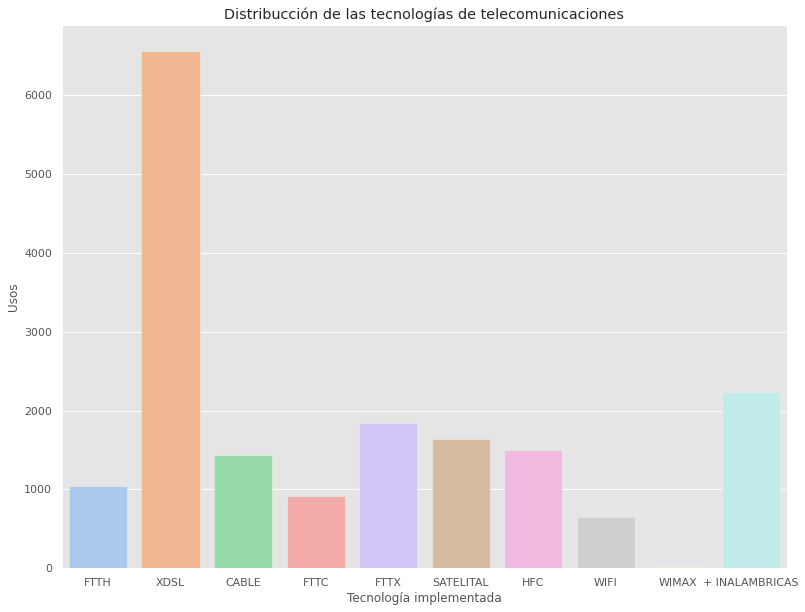

In [564]:
fig, ax = plt.subplots(figsize=(13, 10))
sns_plot = sns.countplot(x='TECNOLOGIA', data=internet_df, ax=ax, palette='pastel')
sns_plot.set(title= "Distribucción de las tecnologías de telecomunicaciones", 
       ylabel= 'Usos',
       xlabel='Tecnología implementada')
plt.show()

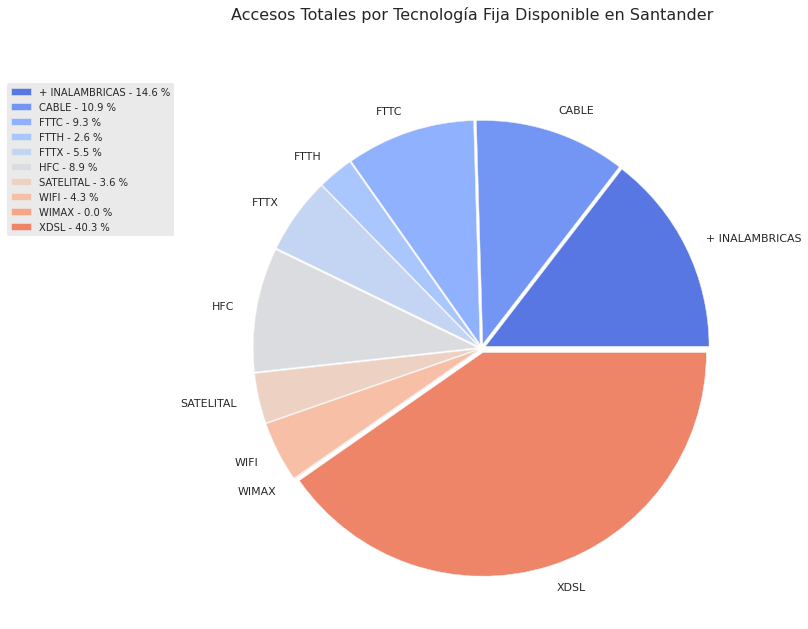

In [565]:
# ACCESOS TOTALES POR TECNOLOGIA
fig, ax = plt.subplots(figsize=(9, 10))
colors = plt.cm.coolwarm(np.linspace(0.1, 0.8, len(acceso_internet['No DE ACCESOS'])))
mexplode = (0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02) 
patches, texts = plt.pie(acceso_internet['No DE ACCESOS'], labels=acceso_internet['TECNOLOGIA'], colors=colors, explode=mexplode)
plt.axis('equal')
plt.rcParams['patch.linewidth'] = 0
porcent = 100*acceso_internet['No DE ACCESOS'] / sum(acceso_internet['No DE ACCESOS'])
labels = ['{0} - {1:1.1f} %'.format(i,j) for i, j in zip(acceso_internet['TECNOLOGIA'], porcent)]
plt.legend(patches, labels, bbox_to_anchor=(-0.1, 1.), fontsize=10)
plt.suptitle('Accesos Totales por Tecnología Fija Disponible en Santander', fontsize=16)
plt.show()

<module 'seaborn' from '/usr/local/lib/python3.7/dist-packages/seaborn/__init__.py'>

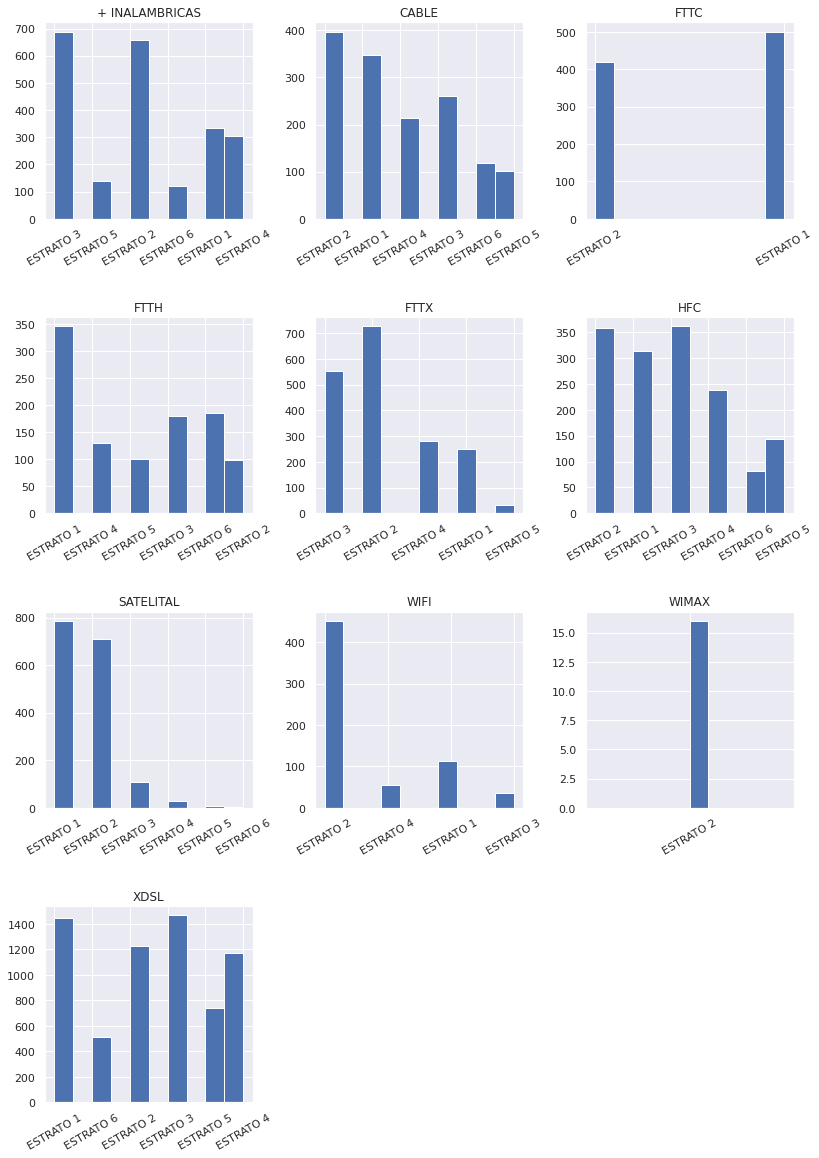

In [566]:
#ACCESO POR TECNOLOGIA Y ESTRATO
sns.set()
internet_df.hist('SEGMENTO','TECNOLOGIA',rot = 30,figsize=(13,20))
sns

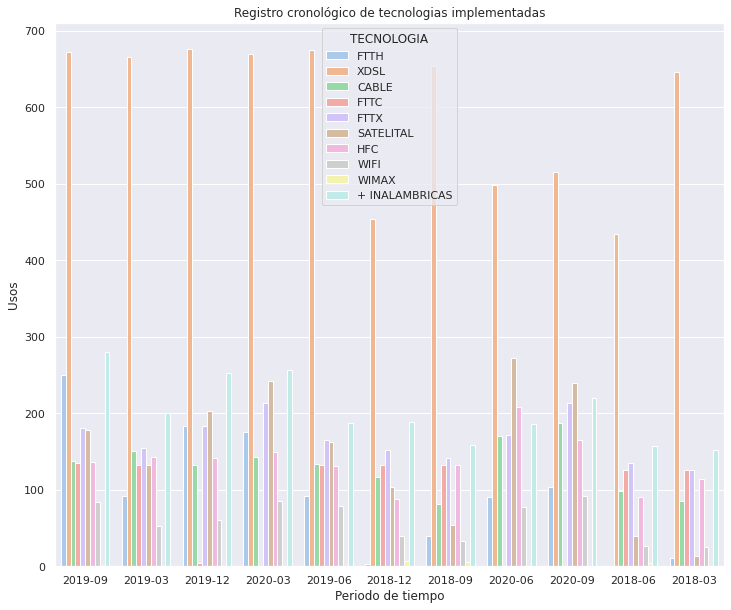

In [567]:
#Usos de tecnologias de la telecomunicaciones en el tiempo
fig, ax = plt.subplots(figsize=(12, 10))
sns_plot = sns.countplot(x='FECHA',hue='TECNOLOGIA',data=internet_df, ax=ax, palette="pastel")
sns_plot.set(title= "Registro cronológico de tecnologias implementadas", 
       ylabel= 'Usos',
       xlabel='Periodo de tiempo')
plt.show()

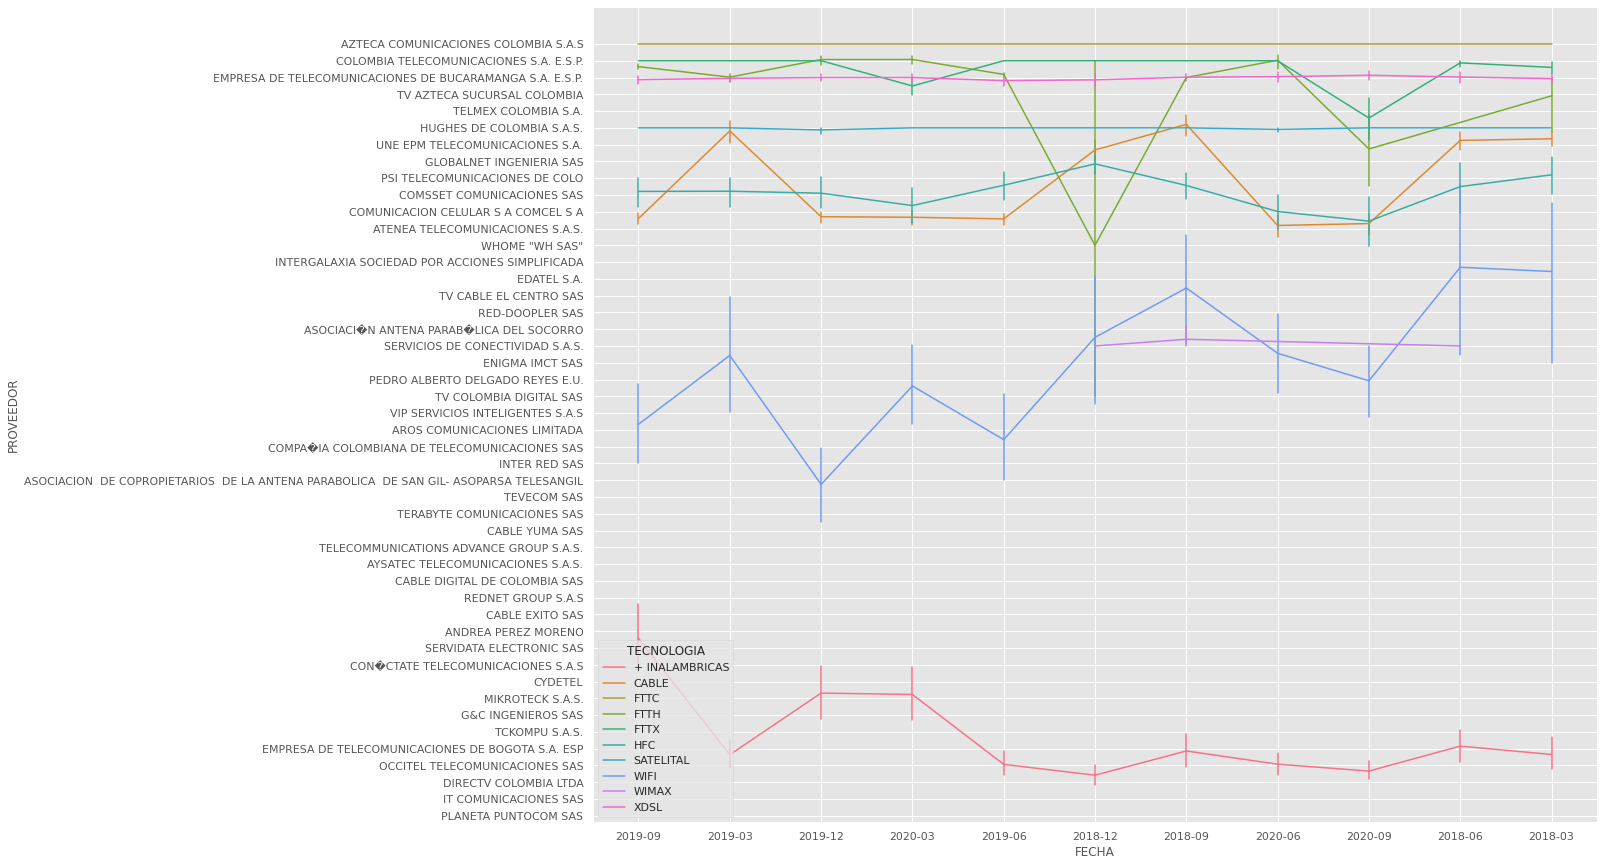

In [628]:
fig, ax = plt.subplots(figsize=(18, 15))
sns.lineplot(x='FECHA', y='PROVEEDOR', hue='TECNOLOGIA', err_style="bars", data=internet_df, ax=ax)

In [569]:
buc_df= internet_df[internet_df['MUNICIPIO']=='BUCARAMANGA']

In [570]:
con = buc_df.loc[:,['FECHA', 'SEGMENTO', 'CABLE']]
con['No DE ACCESOS']= con.groupby(['FECHA','SEGMENTO'])['CABLE'].transform('sum')
con = con.drop_duplicates()
con = con.sort_values("FECHA")
fig=px.bar(con, x='FECHA', y='No DE ACCESOS', color='SEGMENTO', hover_name='SEGMENTO')
fig.show()

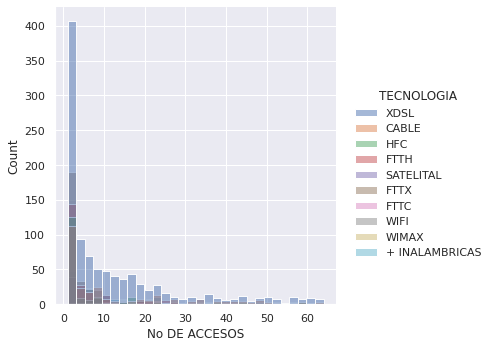

In [571]:
buc_df.groupby('TECNOLOGIA').sum()
sns.displot(buc_df, x="No DE ACCESOS", hue="TECNOLOGIA")

In [572]:
#Gráfica de los municipios con más conexiones de internet fijo
diezmas = pd.DataFrame(internet_df.groupby('MUNICIPIO')['No DE ACCESOS'].sum().nlargest(10).sort_values(ascending = False))
fig1 = px.scatter(diezmas, x = diezmas.index, y = 'No DE ACCESOS', size = 'No DE ACCESOS', size_max = 150,
                color = diezmas.index, title = 'Los diez municipios con más conexiones')
fig1.update_layout(legend=dict(
    yanchor="top",
    y=0.99,
    xanchor="right",
    x=0.99
))
fig1.show()

# *Clustering Jerárquico*



```
Este apartado se baso en el código publicado en los siguientes sitios web:
https://www.jacobsoft.com.mx/es_mx/clustering-jerarquico-con-python/
https://www.techladder.in/article/hierarchical-clustering-algorithm-python
```



In [573]:
internet_df.describe()

,VELOCIDAD_BAJADA,VELOCIDAD_SUBIDA,No DE ACCESOS,+ INALAMBRICAS,CABLE,FTTC,FTTH,FTTX,HFC,SATELITAL,WIFI,WIMAX,XDSL
count,17856.000000,17856.000000,17856.000000,17856.000000,17856.000000,17856.000000,17856.000000,17856.000000,17856.000000,17856.000000,17856.000000,17856.000000,17856.000000
mean,7.673107,1.261705,10.994456,0.125504,0.080645,0.051467,0.058300,0.102991,0.083893,0.092014,0.036682,0.000896,0.367608
std,6.596864,0.585556,14.346503,0.331299,0.272297,0.220955,0.234316,0.303955,0.277236,0.289054,0.187986,0.029922,0.482167
min,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,6.000000,1.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,10.000000,1.000000,15.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,40.000000,3.000000,64.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [574]:
#Codificacion Dataset
internet_df['TECNOLOGIA']=internet_df['TECNOLOGIA'].astype('category')
internet_df['TECNOLOGIA2'] = internet_df['TECNOLOGIA'].cat.codes

In [575]:
#borramos algunas columnas para evitar conflictos con la normalización
internet_df.head()
datos_dropped = internet_df.copy()
datos_dropped = internet_df.drop(internet_df.columns[[0, 1, 2, 3, 4, 5, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]], axis=1)
datos_dropped

,VELOCIDAD_BAJADA,VELOCIDAD_SUBIDA,No DE ACCESOS
0,6,3,1
1,5,1,26
5,2,1,57
6,6,3,1
10,11,1,16
...,...,...,...
52483,1,1,17
52484,6,1,1
52485,6,1,1
52489,7,2,17


In [576]:
#normalizamos los datos
datos_scaled = normalize(datos_dropped)
datos_scaled = pd.DataFrame(datos_scaled, columns=datos_dropped.columns)
datos_scaled.head()

,VELOCIDAD_BAJADA,VELOCIDAD_SUBIDA,No DE ACCESOS
0,0.884652,0.442326,0.147442
1,0.188713,0.037743,0.981307
2,0.035061,0.017530,0.999231
3,0.884652,0.442326,0.147442
4,0.565779,0.051434,0.822951


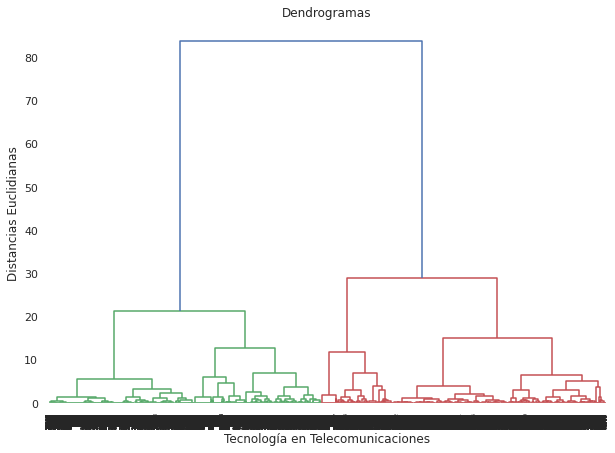

In [ ]:
#Necesitamos conocer la distancia entre cada uno de los puntos, para ello hacemos un dendrograma
plt.figure(figsize=(10, 7))  
plt.title("Dendrogramas")  
plt.xlabel('Tecnología en Telecomunicaciones')
plt.ylabel('Distancias Euclidianas')
dend = shc.dendrogram(shc.linkage(datos_scaled, method='ward',metric='euclidean'))

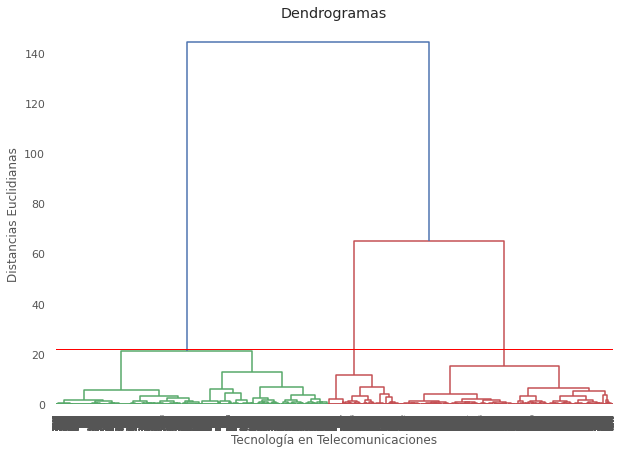

In [ ]:
#Realizamos una línea vertical en el dendrograma
plt.figure(figsize=(10, 7))  
plt.title("Dendrogramas")  
plt.xlabel('Tecnología en Telecomunicaciones')
plt.ylabel('Distancias Euclidianas')
dend = shc.dendrogram(shc.linkage(datos_scaled, method='ward',metric='euclidean'))
# Agregamos una línea horizontal a la altura de 0.4
plt.axhline(y=22, c='red', lw=1, linestyle='solid')

Para definir el número de clúster óptimo se realizo la demarcación de una línea en la mayor diferencia de alturas del dendrograma para observar la distancia máxima, definiendo así que el número de clúster óptimos es 3

In [577]:
#Procedemos a la clusterización acumulativa
hc = AgglomerativeClustering(n_clusters = 3, affinity = 'euclidean', linkage = 'ward')
y_hc = hc.fit_predict(datos_scaled)

In [578]:
X =datos_dropped.values

In [579]:
datos_scaled

,VELOCIDAD_BAJADA,VELOCIDAD_SUBIDA,No DE ACCESOS
0,0.884652,0.442326,0.147442
1,0.188713,0.037743,0.981307
2,0.035061,0.017530,0.999231
3,0.884652,0.442326,0.147442
4,0.565779,0.051434,0.822951
...,...,...,...
17851,0.058621,0.058621,0.996558
17852,0.973329,0.162221,0.162221
17853,0.973329,0.162221,0.162221
17854,0.378517,0.108148,0.919255


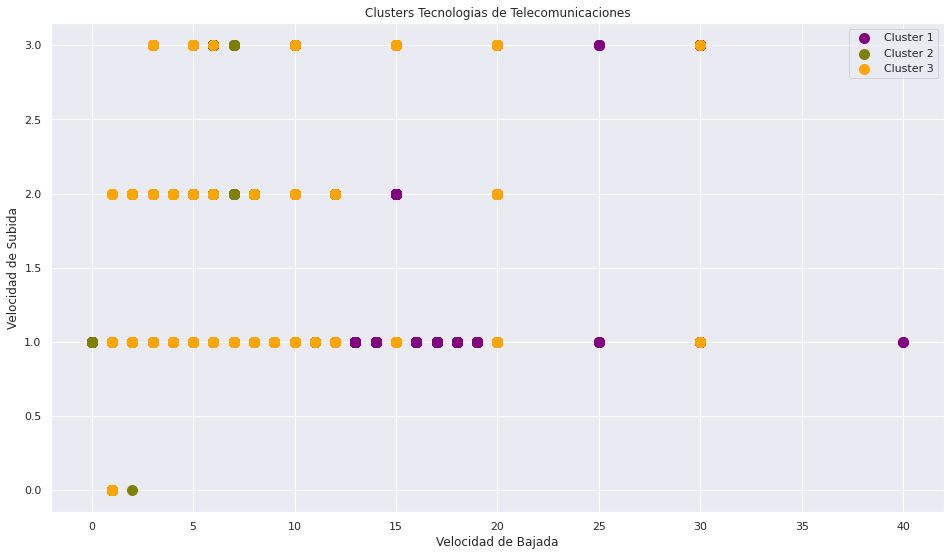

In [580]:
plt.scatter(X[y_hc == 0, 0], X[y_hc == 0, 1], s = 100, c = 'purple', label = 'Cluster 1')
plt.scatter(X[y_hc == 1, 0], X[y_hc == 1, 1], s = 100, c = 'olive', label = 'Cluster 2')
plt.scatter(X[y_hc == 2, 0], X[y_hc == 2, 1], s = 100, c = 'orange', label = 'Cluster 3')
plt.title('Clusters Tecnologias de Telecomunicaciones')
plt.xlabel('Velocidad de Bajada')
plt.ylabel('Velocidad de Subida')
plt.legend()
plt.show()

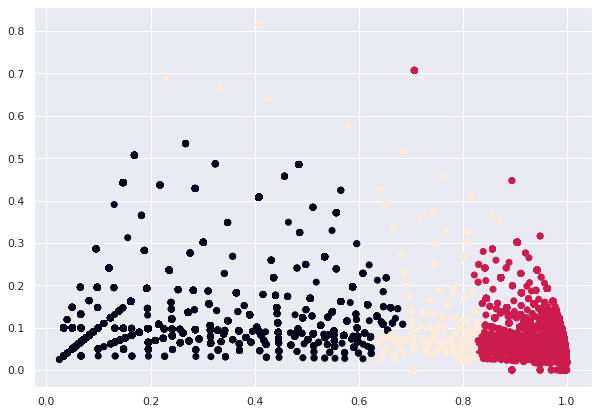

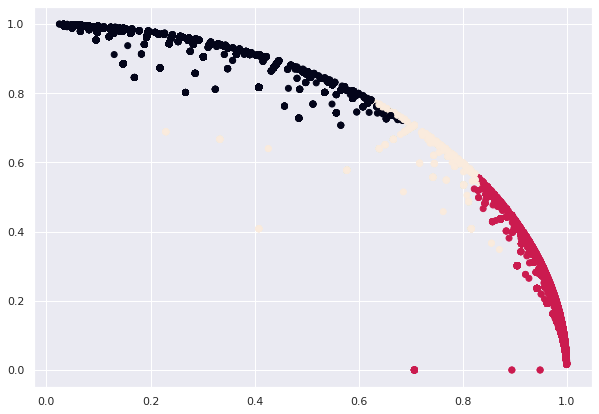

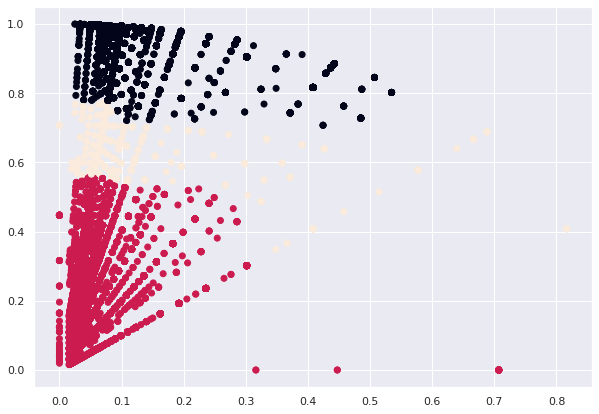

In [581]:
#Se prosige a generar los clusters
cluster = AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='ward')  
cluster.fit_predict(datos_scaled)

plt.figure(figsize=(10, 7))  
plt.scatter(datos_scaled['No DE ACCESOS'], datos_scaled['VELOCIDAD_SUBIDA'], c=cluster.labels_) 

plt.figure(figsize=(10, 7))  
plt.scatter(datos_scaled['No DE ACCESOS'], datos_scaled['VELOCIDAD_BAJADA'], c=cluster.labels_) 

plt.figure(figsize=(10, 7))  
plt.scatter(datos_scaled['VELOCIDAD_SUBIDA'], datos_scaled['VELOCIDAD_BAJADA'], c=cluster.labels_) 



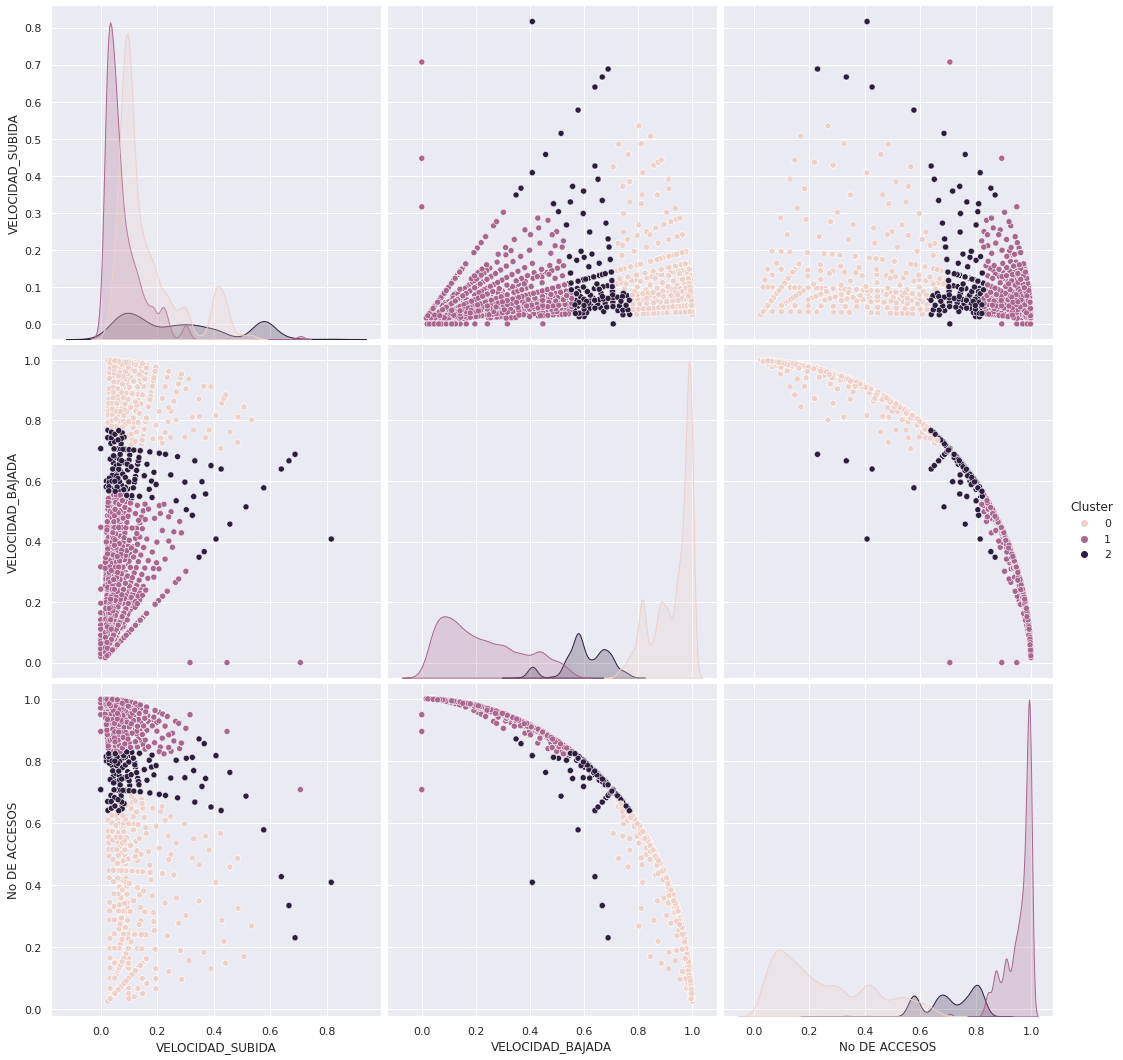

In [582]:
datos_scaled['Cluster']=cluster.labels_
sb.pairplot(datos_scaled.dropna(), hue='Cluster',height=5,vars=['VELOCIDAD_SUBIDA','VELOCIDAD_BAJADA','No DE ACCESOS'],kind='scatter')

#Clustering K-means



```
Este apartado se baso en el código publicado en:
https://www.aprendemachinelearning.com/k-means-en-python-paso-a-paso/
https://heartbeat.fritz.ai/k-means-clustering-using-sklearn-and-python-4a054d67b187
```



In [583]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 9)
plt.style.use('ggplot')

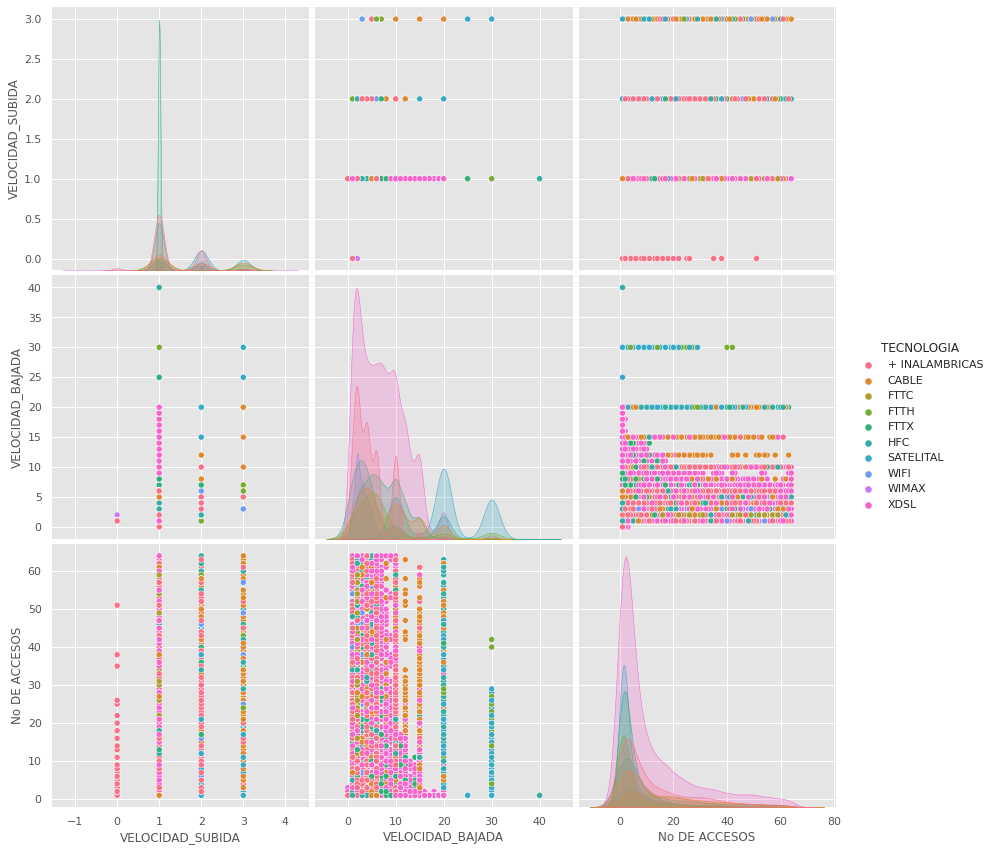

In [584]:
#CRUZAMOS LAS 3 DIMENSIONES Y LAS CRUZAMOS PARA ENCONTRAR PATRONES DE AGRUPACIÓN Y RELACIÓN CON SUS CATEGORIAS
sb.pairplot(internet_df.dropna(), hue='TECNOLOGIA',height=4,vars=['VELOCIDAD_SUBIDA','VELOCIDAD_BAJADA','No DE ACCESOS'],kind='scatter')

In [585]:
#Normalizamos los valores para que sólo quede como máximo el valor 1 y minimo el valor 0
datos_norm = (datos_dropped-datos_dropped.min())/(datos_dropped.max()-datos_dropped.min())
datos_norm

,VELOCIDAD_BAJADA,VELOCIDAD_SUBIDA,No DE ACCESOS
0,0.150,1.000000,0.000000
1,0.125,0.333333,0.396825
5,0.050,0.333333,0.888889
6,0.150,1.000000,0.000000
10,0.275,0.333333,0.238095
...,...,...,...
52483,0.025,0.333333,0.253968
52484,0.150,0.333333,0.000000
52485,0.150,0.333333,0.000000
52489,0.175,0.666667,0.253968


Definimos la cantidad óptima de cluster, para ello hacemos uso del método del codo

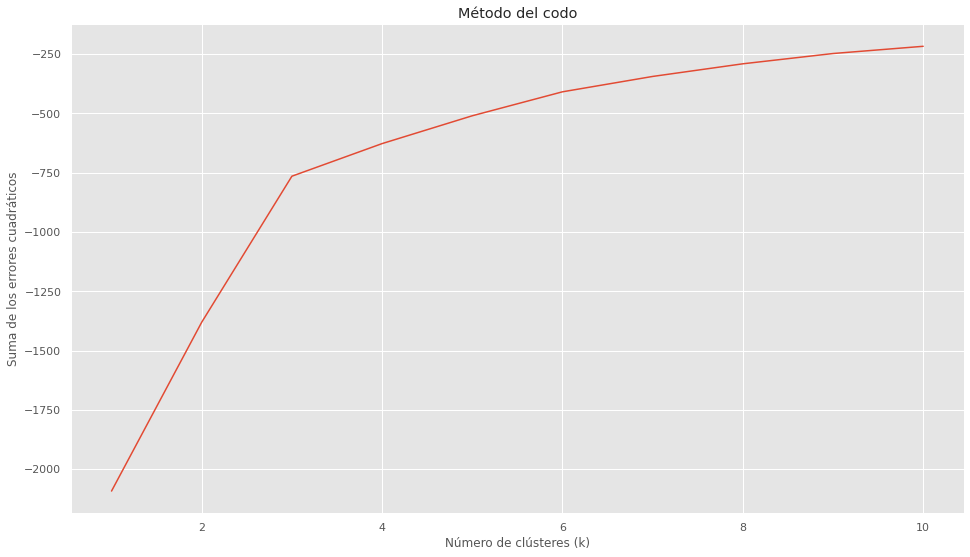

In [586]:
nc = range(1, 11) # El número de iteraciones que queremos hacer.
kmeans = [KMeans(n_clusters=i) for i in nc]
score = [kmeans[i].fit(datos_norm).score(datos_norm) for i in range(len(kmeans))]
plt.plot(nc,score)
plt.title('Método del codo')
plt.xlabel('Número de clústeres (k)')
plt.ylabel('Suma de los errores cuadráticos')
plt.show()

De acuerdo con el gráfico de la curva de codo, se optá por elegir "3" como el número ideal para K

In [587]:
kmeans = KMeans(n_clusters=3, random_state=0)
kmeans.fit(datos_dropped)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=0, tol=0.0001, verbose=0)

In [588]:
kmeans.cluster_centers_

array([[ 8.33707072,  1.28085307,  3.45397522],
       [ 6.21445783,  1.22650602, 47.44096386],
       [ 5.91632772,  1.20772807, 21.35764091]])

In [589]:
kmeans.labels_

array([0, 2, 1, ..., 0, 2, 2], dtype=int32)

In [590]:
unique, counts = np.unique(kmeans.labels_, return_counts=True)
dict_data = dict(zip(unique, counts))
dict_data

{0: 12739, 1: 1660, 2: 3457}

In [591]:
#Guardamos los clusters en el dataframe
internet_df['Kmeans_Cluster'] = kmeans.labels_

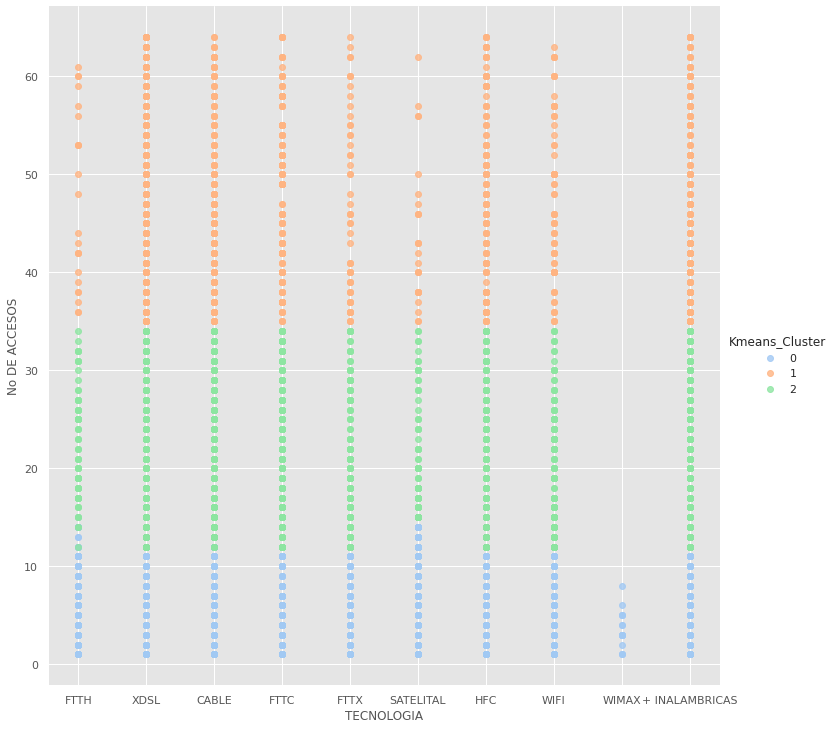

In [592]:
#Visualizamos el clúster
sns.lmplot('TECNOLOGIA', 'No DE ACCESOS', data=internet_df, hue='Kmeans_Cluster', palette="pastel", size=10, aspect=1, fit_reg=False)

In [593]:
x = datos_dropped.values
y_kmeans3 = kmeans.fit_predict(x)

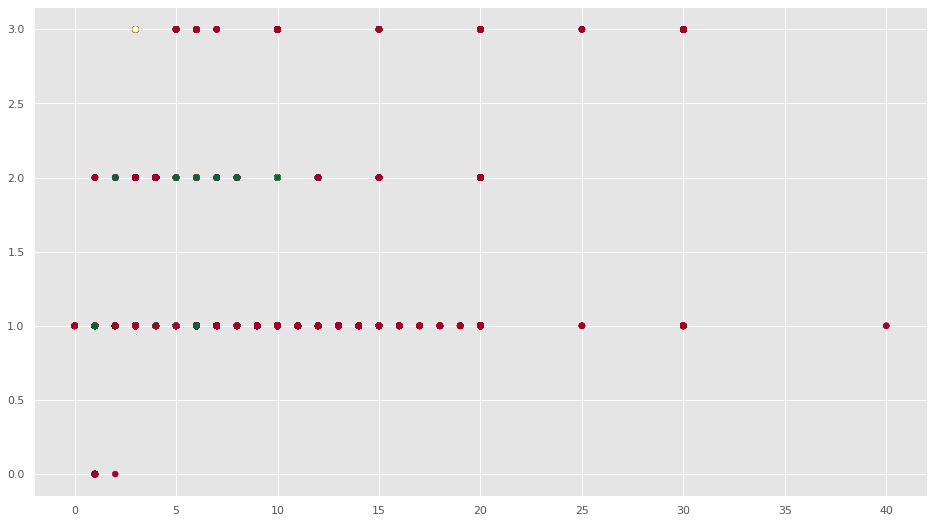

In [594]:
#Visualización 2D de los clústers
plt.scatter(x[:, 0], x[:, 1], c=y_kmeans3, cmap='RdYlGn')

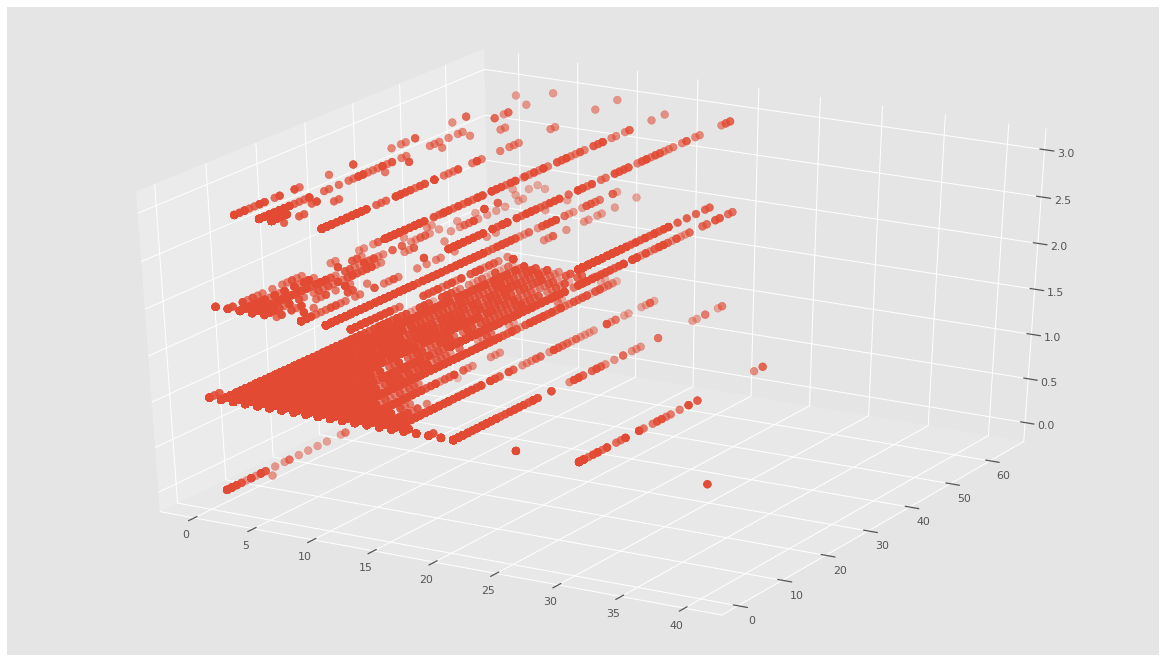

In [595]:
#Visualización 3D de los clústers
X = np.array(internet_df[['VELOCIDAD_BAJADA','No DE ACCESOS', 'VELOCIDAD_SUBIDA']])
Y = np.array(internet_df['TECNOLOGIA2'])
fig = plt.figure()
ax = Axes3D(fig)
colors=['blue','red','green','yellow']
asignar=[]
ax.scatter(X[:, 0], X[:, 1], X[:, 2],s=60)


#Clustering Probabilístico (Gaussian Mixture Models)


```
Este apartado se basó en el código expuesto en:

https://www.analyticsvidhya.com/blog/2019/10/gaussian-mixture-models-clustering/ 

https://towardsdatascience.com/gaussian-mixture-models-for-clustering-3f62d0da675
```




Obtener el número óptimo de componentes

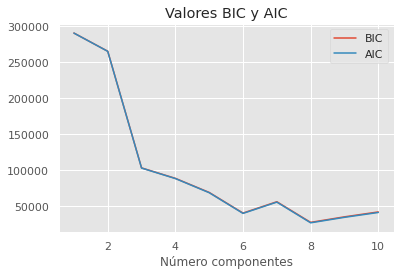

In [596]:
n_components = range(1, 11)
valores_bic = []
valores_aic = []

for i in n_components:
    modelo = GaussianMixture(n_components=i, covariance_type="full")
    modelo = modelo.fit(datos_dropped)
    valores_bic.append(modelo.bic(datos_dropped))
    valores_aic.append(modelo.aic(datos_dropped))

fig, ax = plt.subplots(1, 1, figsize=(6, 3.84))
ax.plot(n_components, valores_bic, label='BIC')
ax.plot(n_components, valores_aic, label='AIC')
ax.set_title("Valores BIC y AIC")
ax.set_xlabel("Número componentes")
ax.legend();

De acuerdo con el resultado obtenido del modelo AIC se opta por entrenar el modelo con un número óptimo de 4 clusters

In [597]:
# Entrenamos el modelo de mezcla gaussiana
gm3 = GaussianMixture(n_components=4, covariance_type="full")
gm3.fit(datos_dropped)
pred = gm3.predict(datos_dropped)

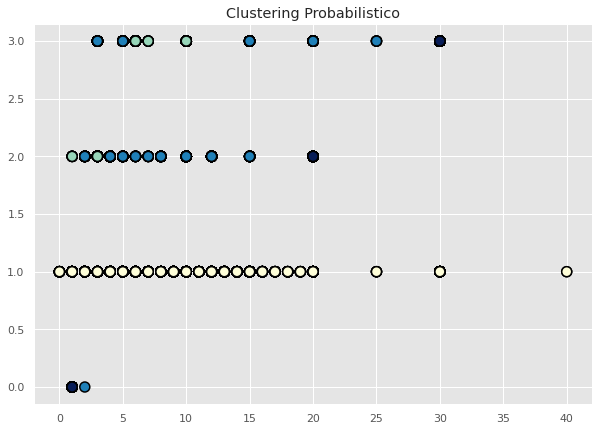

In [598]:
#Visualizaación 2D
plt.figure( figsize=(10,7))
plt.scatter(x[:,0], x[:,1], c=pred, edgecolor='black', lw=1.5, s=100, cmap=plt.get_cmap('YlGnBu'))
plt.title('Clustering Probabilistico')
plt.show()

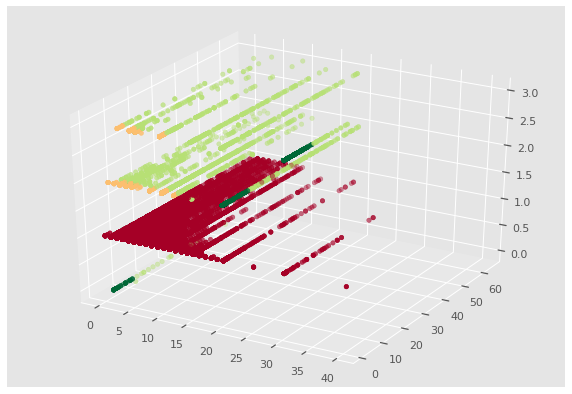

In [599]:
#Visualización en 3D
fig = plt.figure(figsize=(10,7))
ax = plt.axes(projection="3d")
ax.scatter3D(datos_dropped['VELOCIDAD_BAJADA'], datos_dropped['No DE ACCESOS'], datos_dropped['VELOCIDAD_SUBIDA'], c=pred, cmap='RdYlGn')
plt.show()

#Reducción dimensional mediante método Principal Component Analysis



```
Este apartado está basado al tutorial y código publicado en los sitios web:
https://towardsdatascience.com/cronbachs-alpha-theory-and-application-in-python-d2915dd63586
https://www.cienciadedatos.net/documentos/py19-pca-python.html
https://ichi.pro/es/analisis-factorial-en-python-caracterizacion-de-empresas-segun-metricas-financieras-durante-covid19-67481658887023
https://jakevdp.github.io/PythonDataScienceHandbook/05.09-principal-component-analysis.html
https://thepythonlab.com/pca-analisis-de-componentes-principales-en-python/
```



 
Supuesto Multivariante Alfa de Cronbach



In [600]:
#Creamos una copia de datosdropped sin la columna de Cluster Kmeans
datos = datos_dropped.copy()
datos = datos.iloc[:, 0:3]

In [601]:
datos.dtypes

VELOCIDAD_BAJADA    int64
VELOCIDAD_SUBIDA    int64
No DE ACCESOS       int64
dtype: object

In [602]:
def cronbach_alpha(datos):
    # 1. Transform the df into a correlation matrix
    df_corr = datos.corr()
    
    # 2.1 Calculate N
    # The number of variables equals the number of columns in the df
    N = datos.shape[1]
    
    # 2.2 Calculate R
    # For this, we'll loop through the columns and append every
    # relevant correlation to an array calles "r_s". Then, we'll
    # calculate the mean of "r_s"
    rs = np.array([])
    for i, col in enumerate(df_corr.columns):
        sum_ = df_corr[col][i+1:].values
        rs = np.append(sum_, rs)
    mean_r = np.mean(rs)
    
   # 3. Use the formula to calculate Cronbach's Alpha 
    cronbach_alpha = (N * mean_r) / (1 + (N - 1) * mean_r)
    return cronbach_alpha

In [603]:
print(cronbach_alpha(datos))

0.25621511904724814


Supuesto Multivariante Esfericidad de Barlett

In [604]:
print('Bartlett-sphericity Chi-square: {}'.format(calculate_bartlett_sphericity(datos)[0]))
print('Bartlett-sphericity P-value: {}'.format(calculate_bartlett_sphericity(datos)[1]))

Bartlett-sphericity Chi-square: 5214.416274910213
Bartlett-sphericity P-value: 0.0


Supuesto Multivariante Criterio de Kaiser-Meyer-Olkin (KMO)

In [605]:
kmo_all, kmo_model = calculate_kmo(datos[datos.columns]);
print('KMO score: {}'.format(kmo_model));

KMO score: 0.5036067693979795


Análisis Factorial

In [606]:
#Estimación del número de factores y filtrado de variables
fa = FactorAnalyzer(rotation=None)
fa.fit(datos)
ev, v = fa.get_eigenvalues()

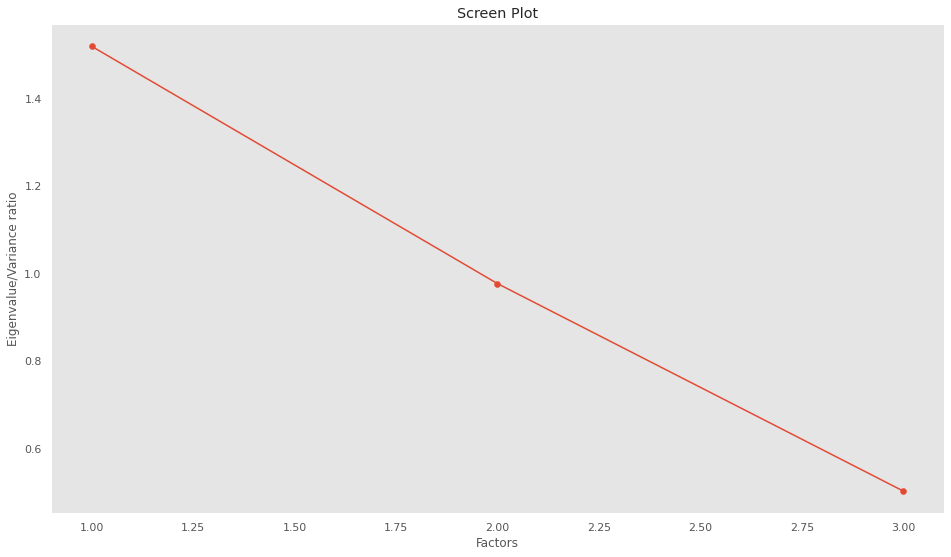

In [607]:
#Se crea la gráfica ScreenPlot correspondiente 
plt.scatter(range(1,datos.shape[1]+1),ev)
plt.plot(range(1,datos.shape[1]+1),ev)
plt.title('Screen Plot')
plt.xlabel('Factors')
plt.ylabel('Eigenvalue/Variance ratio')
plt.grid()
plt.show()

In [608]:
comunalities = pd.DataFrame(fa.get_communalities(), index=list(datos.columns))
features_comm = list(comunalities[comunalities[0] > 0.2].index)
print('Total variables with communalities >0.2: {}'.format(len(features_comm)))

Total variables with communalities >0.2: 2


In [609]:
fa = FactorAnalyzer(rotation="varimax", n_factors=3, method='ml')
fa.fit(datos);
#check eigenvalues
ev, v = fa.get_eigenvalues()

In [610]:
fa_loading_matrix = pd.DataFrame(fa.loadings_, columns=['FA{}'.format(i) for i in range(1, 3+1)],
                                 index=datos.columns)
fa_loading_matrix['Highest_loading'] = fa_loading_matrix.idxmax(axis=1)
fa_loading_matrix = fa_loading_matrix.sort_values('Highest_loading')
fa_loading_matrix

,FA1,FA2,FA3,Highest_loading
VELOCIDAD_BAJADA,0.560143,0.250471,0.0,FA1
VELOCIDAD_SUBIDA,0.557611,0.217465,0.0,FA1
No DE ACCESOS,-0.093644,-0.158085,0.0,FA3


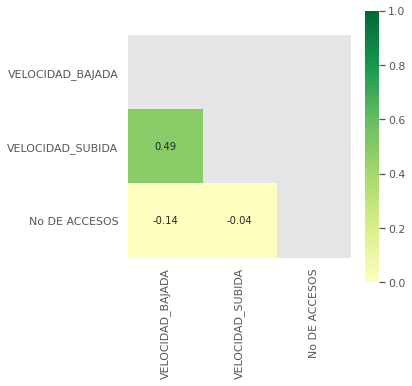

In [611]:
plt.figure(figsize=(5,5))

#plot the heatmap for correlation matrix
corr = datos.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

ax= sns.heatmap(corr,
                vmin=0, vmax=1, center=0,
                cmap='RdYlGn',
                mask=mask, square=True,
                annot=True, fmt='.2f')

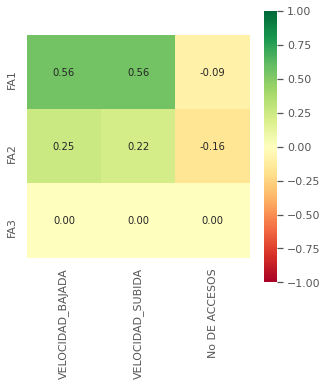

In [612]:
plt.figure(figsize=(5,5))

#plot the heatmap for correlation matrix
ax= sns.heatmap(fa_loading_matrix.drop('Highest_loading', axis=1).T,
                vmin=-1, vmax=1, center=0,
                cmap='RdYlGn',
                square=True, annot=True, fmt='.2f')

In [613]:
fa.get_factor_variance()

(array([0.63345964, 0.13501777, 0.        ]),
 array([0.21115321, 0.04500592, 0.        ]),
 array([0.21115321, 0.25615914, 0.25615914]))

Implementación de Modelo PCA

In [614]:
print('----------------------')
print('Media de cada variable')
print('----------------------')
datos_dropped.mean(axis=0)

----------------------
Media de cada variable
----------------------


VELOCIDAD_BAJADA     7.673107
VELOCIDAD_SUBIDA     1.261705
No DE ACCESOS       10.994456
dtype: float64

In [615]:
print('-------------------------')
print('Varianza de cada variable')
print('-------------------------')
datos_dropped.var(axis=0)

-------------------------
Varianza de cada variable
-------------------------


VELOCIDAD_BAJADA     43.518618
VELOCIDAD_SUBIDA      0.342876
No DE ACCESOS       205.822148
dtype: float64

In [616]:
# Entrenamiento modelo PCA con escalado de los datos
pca_pipe = make_pipeline(StandardScaler(), PCA())
pca_pipe.fit(datos)# obtener los componentes principales
# Se extrae el modelo entrenado del pipeline
modelo_pca = pca_pipe.named_steps['pca']

In [617]:
# Se combierte el array a dataframe para añadir nombres a los ejes.
pd.DataFrame(
    data    = modelo_pca.components_,
    columns = datos.columns,
    index   = ['PC1', 'PC2', 'PC3']
)

,VELOCIDAD_BAJADA,VELOCIDAD_SUBIDA,No DE ACCESOS
PC1,0.697257,0.675770,-0.239097
PC2,0.075412,0.262549,0.961967
PC3,0.712844,-0.688769,0.132103


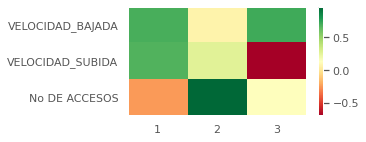

In [618]:
#Heatmap components
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4, 2))
componentes = modelo_pca.components_
plt.imshow(componentes.T, cmap='RdYlGn', aspect='auto')
plt.yticks(range(len(datos.columns)), datos.columns)
plt.xticks(range(len(datos.columns)), np.arange(modelo_pca.n_components_) + 1)
plt.grid(False)
plt.colorbar();

Visualización de varianza por componente y acumulada

----------------------------------------------------
Porcentaje de varianza explicada por cada componente
----------------------------------------------------
[0.50665027 0.32575176 0.16759797]


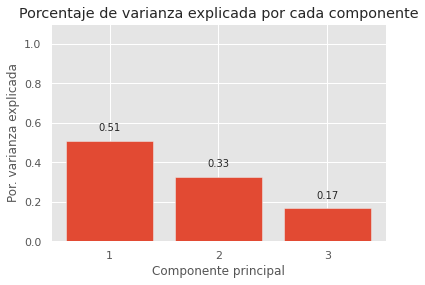

In [619]:
# Porcentaje de varianza explicada por cada componente
# ==============================================================================
print('----------------------------------------------------')
print('Porcentaje de varianza explicada por cada componente')
print('----------------------------------------------------')
print(modelo_pca.explained_variance_ratio_)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 4))
ax.bar(
    x      = np.arange(modelo_pca.n_components_) + 1,
    height = modelo_pca.explained_variance_ratio_
)

for x, y in zip(np.arange(len(datos.columns)) + 1, modelo_pca.explained_variance_ratio_):
    label = round(y, 2)
    ax.annotate(
        label,
        (x,y),
        textcoords="offset points",
        xytext=(0,10),
        ha='center'
    )

ax.set_xticks(np.arange(modelo_pca.n_components_) + 1)
ax.set_ylim(0, 1.1)
ax.set_title('Porcentaje de varianza explicada por cada componente')
ax.set_xlabel('Componente principal')
ax.set_ylabel('Por. varianza explicada');

------------------------------------------
Porcentaje de varianza explicada acumulada
------------------------------------------
[0.50665027 0.83240203 1.        ]


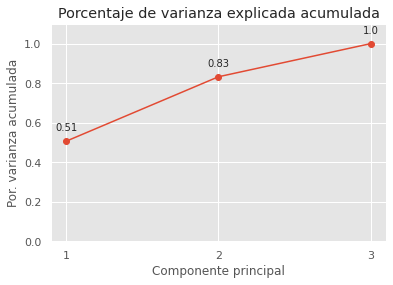

In [620]:
# Porcentaje de varianza explicada acumulada
# ==============================================================================
prop_varianza_acum = modelo_pca.explained_variance_ratio_.cumsum()
print('------------------------------------------')
print('Porcentaje de varianza explicada acumulada')
print('------------------------------------------')
print(prop_varianza_acum)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 4))
ax.plot(
    np.arange(len(datos.columns)) + 1,
    prop_varianza_acum,
    marker = 'o'
)

for x, y in zip(np.arange(len(datos.columns)) + 1, prop_varianza_acum):
    label = round(y, 2)
    ax.annotate(
        label,
        (x,y),
        textcoords="offset points",
        xytext=(0,10),
        ha='center'
    )
    
ax.set_ylim(0, 1.1)
ax.set_xticks(np.arange(modelo_pca.n_components_) + 1)
ax.set_title('Porcentaje de varianza explicada acumulada')
ax.set_xlabel('Componente principal')
ax.set_ylabel('Por. varianza acumulada');

In [621]:
#Instanciamos objeto PCA y aplicamos
pca=PCA(n_components=2) # Otra opción es instanciar pca sólo con dimensiones nuevas hasta obtener un mínimo "explicado" ej.: pca=PCA(.85)
pca.fit(X_scaled) # obtener los componentes principales
X_pca=pca.transform(X_scaled) # convertimos nuestros datos con las nuevas dimensiones de PCA
 
print("shape of X_pca", X_pca.shape)
expl = pca.explained_variance_ratio_
print(expl)
print('suma:',sum(expl[0:2]))

shape of X_pca (17856, 2)
[0.50665027 0.32575176]
suma: 0.8324020342149947


Por tanto, con 2 componentes tenemos algo mas del 83% de varianza explicada

In [622]:
# Proyección de las observaciones de entrenamiento
# ==============================================================================
proyecciones = pca_pipe.transform(X=datos)# convertimos nuestros datos con las nuevas dimensiones de PCA
proyecciones = pd.DataFrame(
    data= proyecciones,
    columns = ['PC1', 'PC2', 'PC3'],
    index   = datos.index
)
proyecciones.head()

,PC1,PC2,PC3
0,1.995890,0.090132,-2.317581
1,-0.834663,0.858282,0.157159
5,-1.668415,2.902670,0.118432
6,1.995890,0.090132,-2.317581
10,-0.033811,0.256330,0.713442


In [623]:
pca = PCA(2)  # project from 64 to 2 dimensions
projected = pca.fit_transform(datos)
print(datos.shape)
print(projected.shape)

(17856, 3)
(17856, 2)


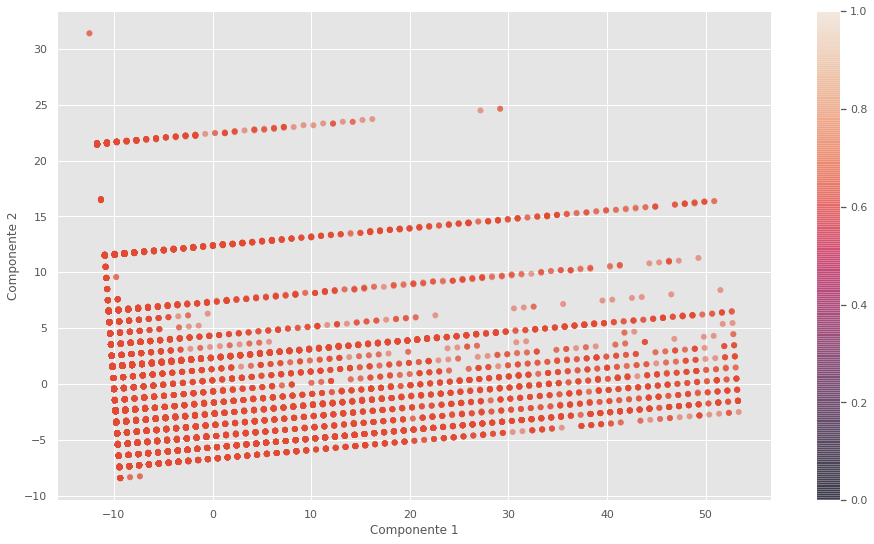

In [624]:
plt.scatter(projected[:, 0], projected[:, 1],
            edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('RdYlGn', 10))
plt.xlabel('Componente 1')
plt.ylabel('Componente 2')
plt.colorbar();

In [625]:
# Recostruccion de las proyecciones
# ==============================================================================
recostruccion = pca_pipe.inverse_transform(X=proyecciones)
recostruccion = pd.DataFrame(
                    recostruccion,
                    columns = datos.columns,
                    index   = datos.index
)
print('------------------')
print('Valores originales')
print('------------------')
display(recostruccion.head())

print('---------------------')
print('Valores reconstruidos')
print('---------------------')
display(datos.head())

------------------
Valores originales
------------------


,VELOCIDAD_BAJADA,VELOCIDAD_SUBIDA,No DE ACCESOS
0,6.0,3.0,1.0
1,5.0,1.0,26.0
5,2.0,1.0,57.0
6,6.0,3.0,1.0
10,11.0,1.0,16.0


---------------------
Valores reconstruidos
---------------------


,VELOCIDAD_BAJADA,VELOCIDAD_SUBIDA,No DE ACCESOS
0,6,3,1
1,5,1,26
5,2,1,57
6,6,3,1
10,11,1,16
